In [1]:
# !pip install SimpleITK
# !pip install matplotlib
# !pip install scikit-learn
# !pip install segmentation_models

In [2]:
import SimpleITK as sitk
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# adc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/1ADC_ss'
adc_folder_path = 'BONBID2023_Train/1ADC_ss'
adc_files = [os.path.join(adc_folder_path, f) for f in os.listdir(adc_folder_path) if f.endswith('.mha')]
adc_files = sorted(adc_files)

In [4]:
# zadc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/2Z_ADC'
zadc_folder_path = 'BONBID2023_Train/2Z_ADC'
zadc_files = [os.path.join(zadc_folder_path, f) for f in os.listdir(zadc_folder_path) if f.endswith('.mha')]
zadc_files = sorted(zadc_files)

In [5]:
# label_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/3LABEL'
label_folder_path = 'BONBID2023_Train/3LABEL'
label_files = [os.path.join(label_folder_path, f) for f in os.listdir(label_folder_path) if f.endswith('.mha')]
label_files = sorted(label_files)

# **Read and display data**

Read and display ADC data

In [6]:
adc_data = []
adc_stik_data = []
for file in adc_files:
    image = sitk.ReadImage(file)
    adc_stik_data.append(image)
    array = sitk.GetArrayFromImage(image)
    adc_data.append(array)

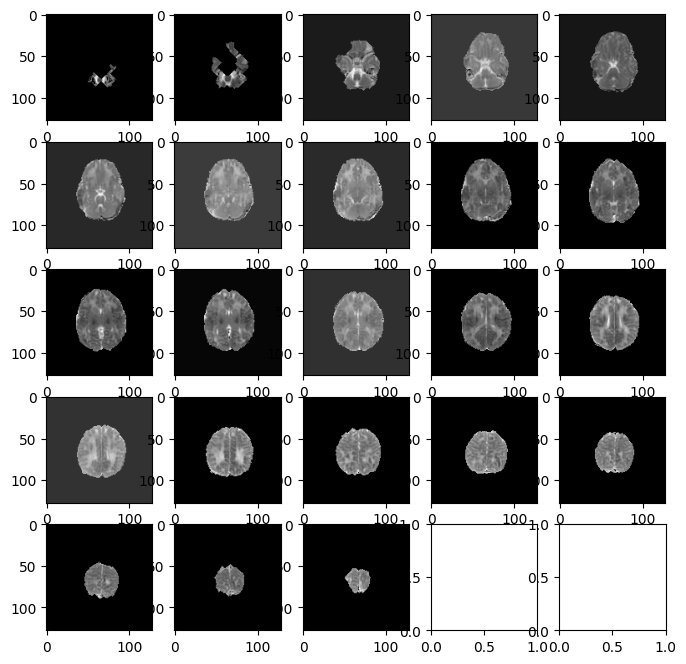

In [7]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < adc_data[0].shape[0]:
        ax.imshow(adc_data[0][i], cmap='gray')

Read and display Zadc data

In [8]:
zadc_data = []
for file in zadc_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    zadc_data.append(array)

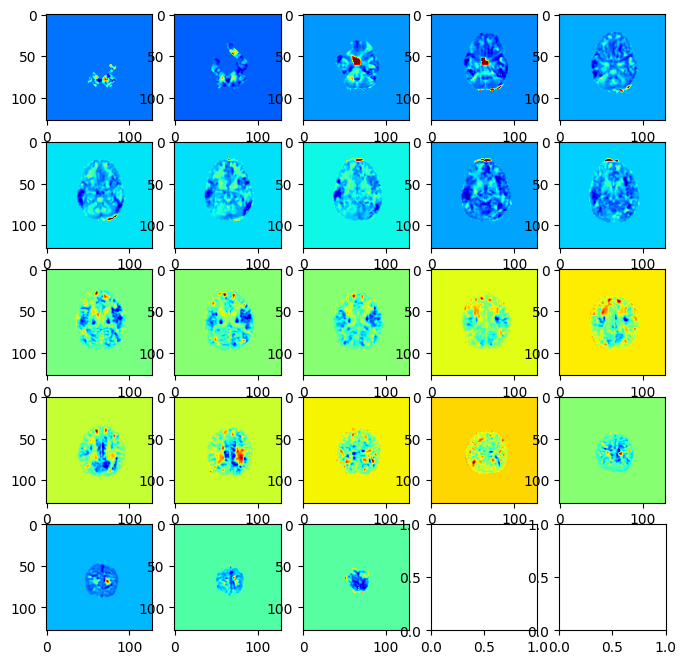

In [9]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < zadc_data[0].shape[0]:
        ax.imshow(zadc_data[0][i], cmap="jet")

Read and display label data

In [10]:
label_data = []
for file in label_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    label_data.append(array)

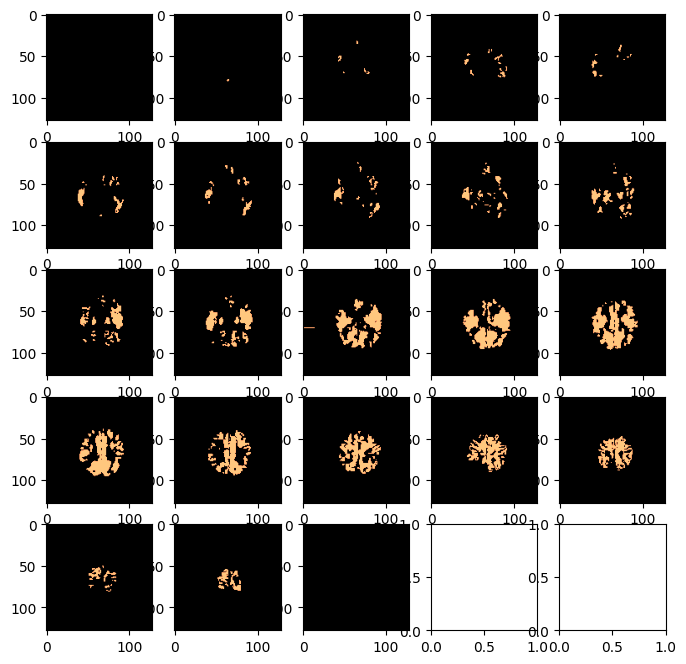

In [11]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < label_data[0].shape[0]:
        ax.imshow(label_data[0][i], cmap="copper")

# **Ready data for training**

In [12]:
# Flatten a list of data with n length and (m, 128, 128) shape of each array, so it becomes a list of n*m of arrays of shape (128, 128)

flattened_adc_data = [item for sublist in adc_data for item in sublist]
flattened_zadc_data = [item for sublist in zadc_data for item in sublist]
flattened_label_data = [item for sublist in label_data for item in sublist]


In [13]:
def slice_image(image):
    """
    Slices the given image into 64x64 patches.
    
    Args:
    image (numpy.ndarray): The image to be sliced, expected shape is (H, W).
    
    Returns:
    list: A list of 64x64 image patches.
    """
    patches = []
    h, w = image.shape
    
    if (h, w) == (256, 256):
        # Slicing 256x256 image into sixteen non-overlapping 64x64 patches
        for i in range(0, h, 64):
            for j in range(0, w, 64):
                patches.append(image[i:i+64, j:j+64])
    elif (h, w) == (160, 160):
        # Slicing 160x160 image with overlap to create 64x64 patches
        for i in range(0, h-64+1, 64):
            for j in range(0, w-64+1, 64):
                patches.append(image[i:i+64, j:j+64])
        # Adding overlapping patches
        patches.append(image[96:160, 96:160])
    elif (h, w) == (128, 128):
        # Slicing 128x128 image with overlap to create 64x64 patches
        for i in range(0, h-64+1, 64):
            for j in range(0, w-64+1, 64):
                patches.append(image[i:i+64, j:j+64])
    elif (h, w) == (64, 64):
        # Returning the image itself if it's already 64x64
        patches.append(image)
    else:
        raise ValueError("Unsupported image size. Expected (64, 64), (128, 128), (160, 160), or (256, 256).")
    
    return patches

def process_images_and_labels(images, labels):
    """
    Processes lists of images and labels, slicing each into 64x64 patches.
    
    Args:
    images (list): List of numpy.ndarray images.
    labels (list): List of numpy.ndarray labels corresponding to the images.
    
    Returns:
    tuple: Two lists containing the sliced images and corresponding labels.
    """
    all_image_patches = []
    all_label_patches = []
    
    for image, label in zip(images, labels):
        image_patches = slice_image(image)
        label_patches = slice_image(label)
        
        all_image_patches.extend(image_patches)
        all_label_patches.extend(label_patches)
    
    return all_image_patches, all_label_patches


In [14]:
flattened_cropped_zadc_data_list, flattened_cropped_label_data_list = process_images_and_labels(flattened_zadc_data, flattened_label_data)

In [15]:
len(flattened_cropped_zadc_data_list)

25772

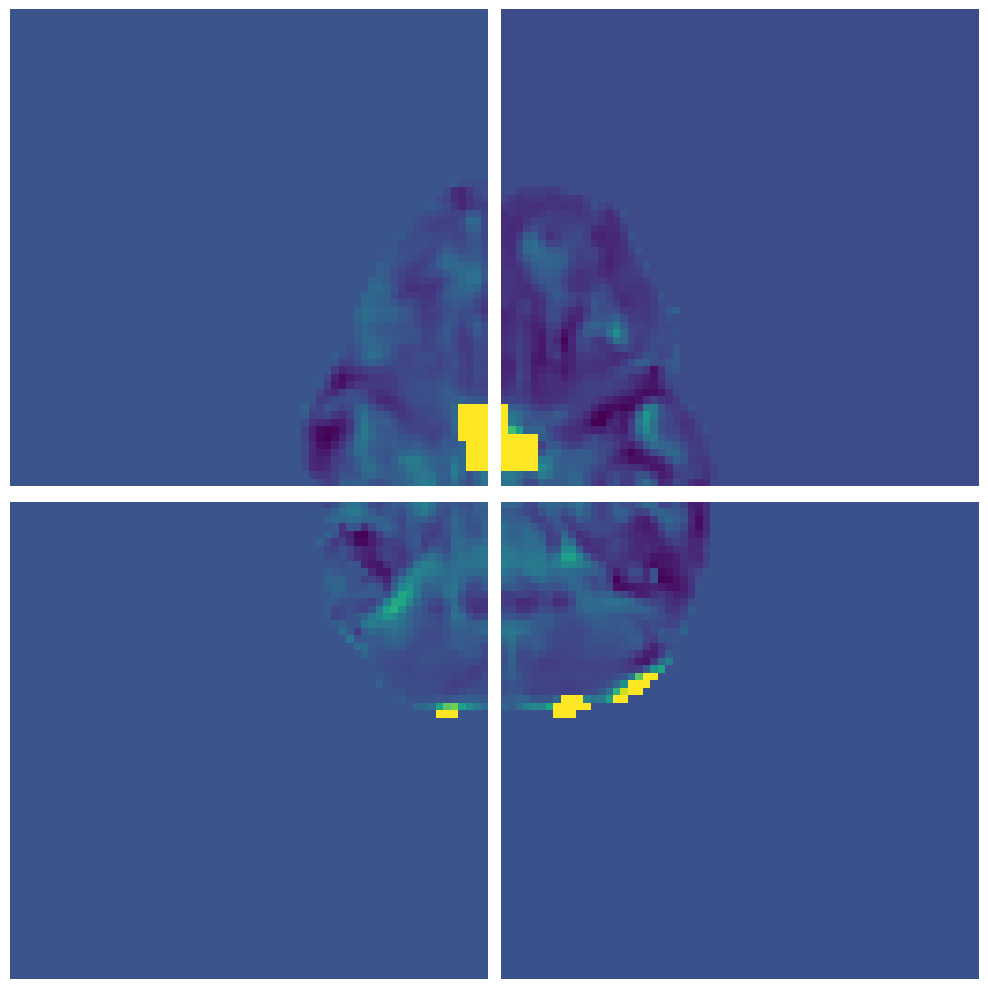

In [16]:
def display_patches(original_image, patches):
    """
    Display the 64x64 patches in a grid to verify their placement.
    
    Args:
    original_image (numpy.ndarray): The original image before slicing.
    patches (list): A list of 64x64 image patches.
    """
    h, w = original_image.shape
    fig, axs = plt.subplots(h // 64, w // 64, figsize=(10, 10))
    
    patch_index = 0
    for i in range(h // 64):
        for j in range(w // 64):
            axs[i, j].imshow(patches[patch_index])
            axs[i, j].axis('off')
            patch_index += 1

    plt.tight_layout()
    plt.show()

# Display patches for the first image
original_image = flattened_zadc_data[3]
patches = slice_image(original_image)
display_patches(original_image, patches)

In [17]:
# Convert the list of arrays to a single NumPy array
flattened_cropped_zadc_data = np.array(flattened_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_cropped_zadc_data = flattened_cropped_zadc_data.reshape((len(flattened_cropped_zadc_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_cropped_label_data = np.array(flattened_cropped_label_data_list)
flattened_cropped_label_data = flattened_cropped_label_data.reshape((len(flattened_cropped_label_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_cropped_label_data.shape)

(25772, 64, 64, 1)
(25772, 64, 64, 1)


# **U Net**

In [18]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
# Segmentation Models: using `keras` framework.

Segmentation Models: using `tf.keras` framework.


In [19]:
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from segmentation_models import Unet

# def dice_loss(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred)
#     denominator = tf.reduce_sum(y_true + y_pred)
#     return 1 - numerator / (denominator + tf.keras.backend.epsilon())

# def iou_score(y_true, y_pred):
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true + y_pred) - intersection
#     return intersection / (union + tf.keras.backend.epsilon())

# def f_score(y_true, y_pred):
#     beta = 1
#     numerator = (1 + beta ** 2) * tf.reduce_sum(y_true * y_pred)
#     denominator = (beta ** 2 * tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
#     return numerator / (denominator + tf.keras.backend.epsilon())

# # Assuming your data is already loaded in variables `flattened_cropped_zadc_data` and `flattened_cropped_label_data`
# BACKBONE = 'resnet34'

# # Split data
# x_train, x_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# # Define the model
# model = Unet(BACKBONE, encoder_weights=None, input_shape=(64, 64, 1))

# # Compile the model with custom DiceLoss and metrics
# model.compile(
#     optimizer='Adam',
#     loss=dice_loss,
#     metrics=[iou_score, f_score]
# )

# # Fit the model
# model.fit(
#    x=x_train,
#    y=y_train,
#    batch_size=16,
#    epochs=10,
#    validation_data=(x_val, y_val)
# )


In [20]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

BACKBONE = 'resnet34'

# load your data
x_train, x_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# define model
model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(64, 64, 1))
model.compile(
    'Adam',
    loss=sm.losses.DiceLoss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=20,
   validation_data=(x_val, y_val)
)

Epoch 1/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 292s 430ms/step - f1-score: 0.4213 - iou_score: 0.3215 - loss: 0.5787 - val_f1-score: 0.7126 - val_iou_score: 0.6040 - val_loss: 0.2853
Epoch 2/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 273s 424ms/step - f1-score: 0.6726 - iou_score: 0.5496 - loss: 0.3274 - val_f1-score: 0.7239 - val_iou_score: 0.6153 - val_loss: 0.2746
Epoch 3/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 271s 420ms/step - f1-score: 0.6847 - iou_score: 0.5595 - loss: 0.3153 - val_f1-score: 0.7158 - val_iou_score: 0.6092 - val_loss: 0.2821
Epoch 4/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 271s 421ms/step - f1-score: 0.6909 - iou_score: 0.5666 - loss: 0.3091 - val_f1-score: 0.5313 - val_iou_score: 0.4093 - val_loss: 0.4662
Epoch 5/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 273s 423ms/step - f1-score: 0.7360 - iou_score: 0.6156 - loss: 0.2640 - val_f1-score: 0.7309 - val_iou_score: 0.6259 - val_loss: 0.2667
Epoch 6/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 272s 421ms/step - f1-score: 0.7028 - iou_score: 0.5813 - loss: 0.2972 - val_f1-s

In [ ]:
model.summary()

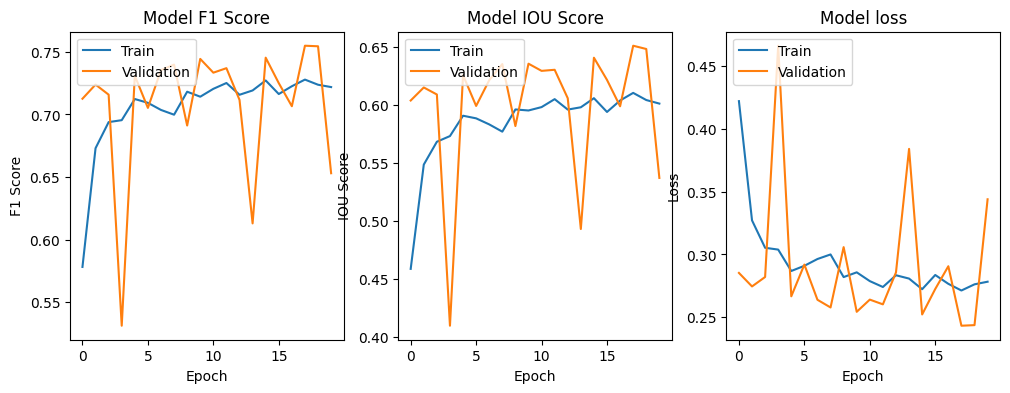

In [26]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


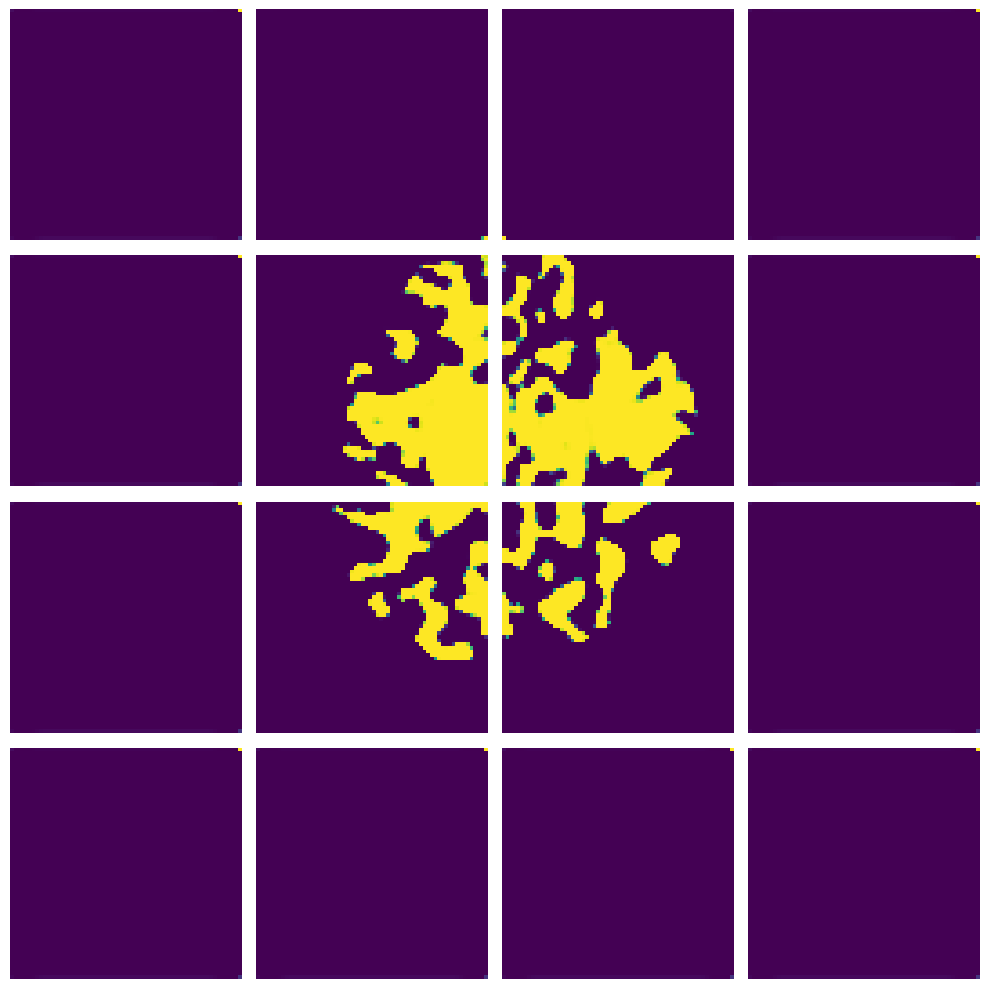

In [22]:
original_image = flattened_zadc_data[500]
patches = slice_image(original_image)

patches_data = np.array(patches)

# Reshape the array to have shape (num_samples, 128, 128, 1)
patches_data = patches_data.reshape((len(patches), 64, 64, 1))

predictions = model.predict(patches_data)
display_patches(original_image, predictions)

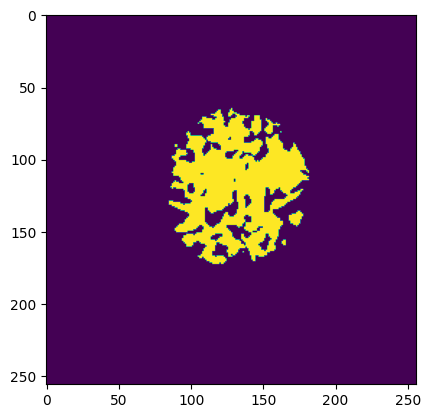

In [23]:
plt.imshow(flattened_label_data[500])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


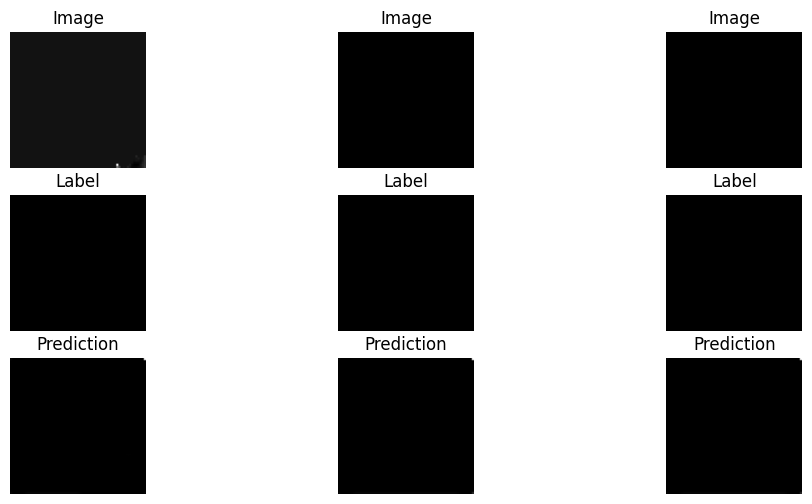

In [24]:
images = x_val[200:203]
labels = y_val[200:203]
# Get model predictions on a few samples
predictions = model.predict(images)

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(64, 64), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(64, 64), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(images, labels, predictions)


In [27]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

BACKBONE = 'resnet34'

# load your data
x_train, x_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# define model
model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(64, 64, 1))
model.compile(
    'Adam',
    loss=sm.losses.DiceLoss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=5,
   validation_data=(x_val, y_val)
)

Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 963s 1s/step - f1-score: 0.4480 - iou_score: 0.3432 - loss: 0.5520 - val_f1-score: 0.6812 - val_iou_score: 0.5653 - val_loss: 0.3194
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 456s 706ms/step - f1-score: 0.6999 - iou_score: 0.5699 - loss: 0.3001 - val_f1-score: 0.6889 - val_iou_score: 0.5658 - val_loss: 0.3112
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 269s 416ms/step - f1-score: 0.7005 - iou_score: 0.5760 - loss: 0.2995 - val_f1-score: 0.6037 - val_iou_score: 0.4775 - val_loss: 0.3958
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 268s 416ms/step - f1-score: 0.7050 - iou_score: 0.5816 - loss: 0.2950 - val_f1-score: 0.7272 - val_iou_score: 0.6117 - val_loss: 0.2709
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 273s 423ms/step - f1-score: 0.6755 - iou_score: 0.5502 - loss: 0.3245 - val_f1-score: 0.6498 - val_iou_score: 0.5344 - val_loss: 0.3476


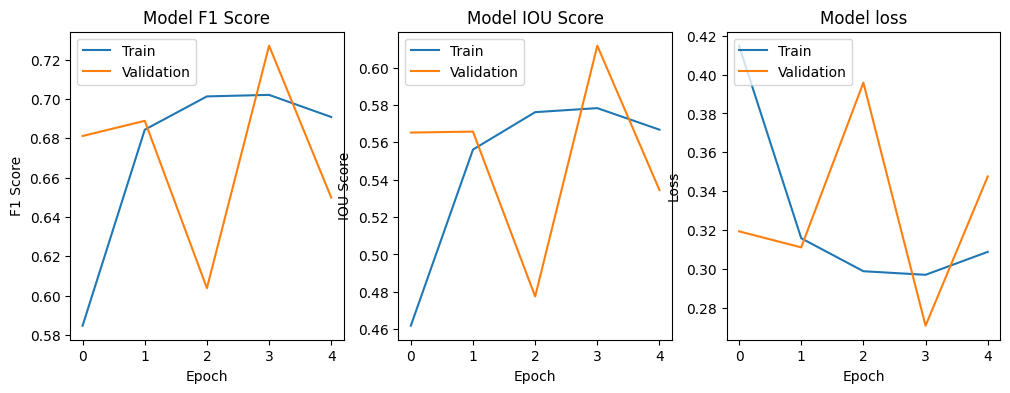

In [28]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


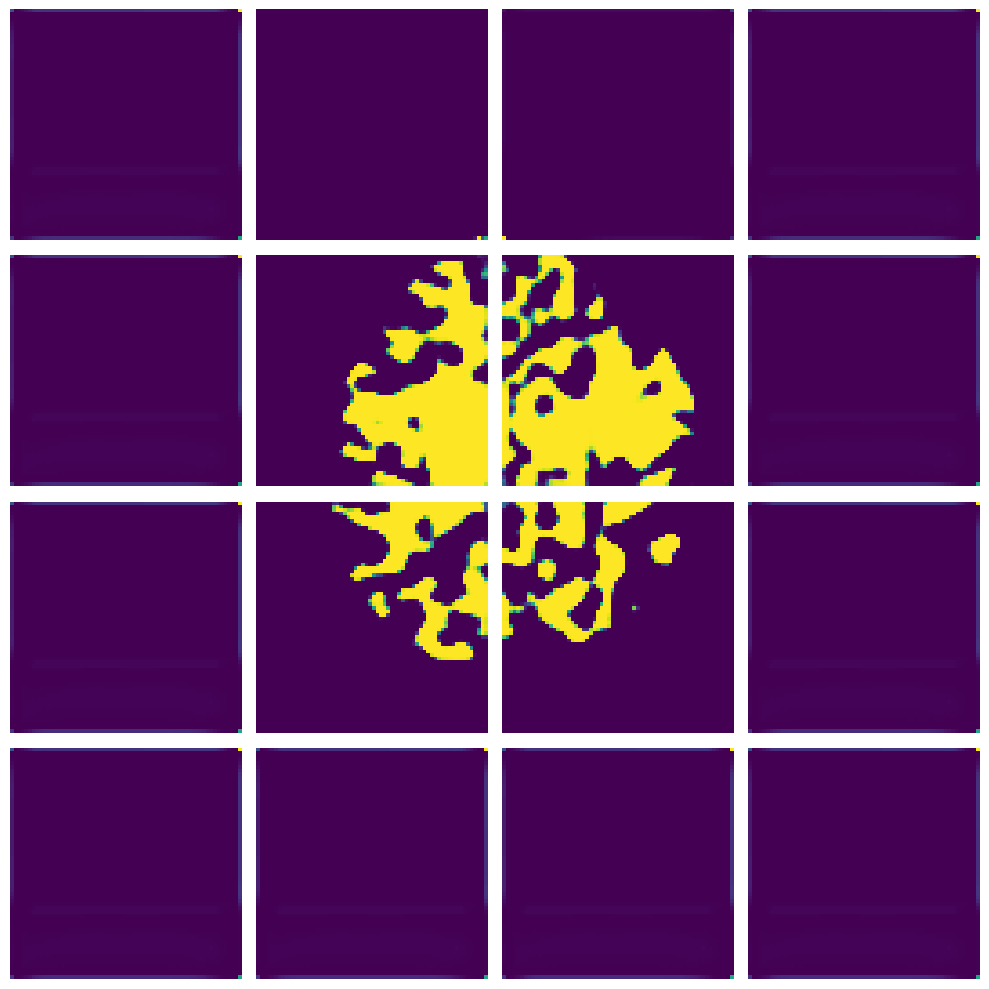

In [29]:
original_image = flattened_zadc_data[500]
patches = slice_image(original_image)

patches_data = np.array(patches)

# Reshape the array to have shape (num_samples, 128, 128, 1)
patches_data = patches_data.reshape((len(patches), 64, 64, 1))

predictions = model.predict(patches_data)
display_patches(original_image, predictions)

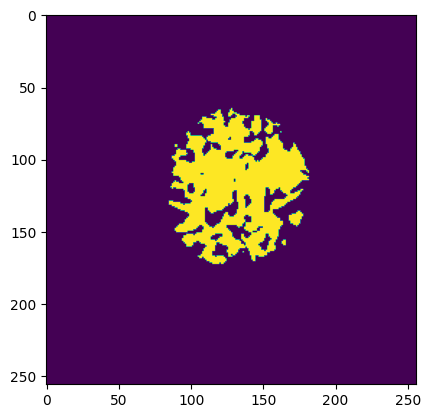

In [30]:
plt.imshow(flattened_label_data[500])